<a href="https://colab.research.google.com/github/xwang222/My-Projects/blob/main/IPW_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### This notebook is a modified version of https://gist.github.com/BioSciEconomist/826556977841cbf966f03542b2be0c55

Compared to the original notebook, I showed how to reconcile the results from package with my calculation from scratch.

In [1]:
# Import pandas  and numpy
import pandas as pd
import numpy as np
import statsmodels.api as sm # import stastmodels
import statsmodels.formula.api as smf # this allows us to use an explicit formulation
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t
df = pd.read_csv('/content/drive/MyDrive/londe.csv')

#### Produce Propensity Score

In [2]:
model = smf.glm('treat ~ age + educ + black + hispan + married + nodegree + re74 + re75', 
                data=df, family=sm.families.Binomial(link = sm.genmod.families.links.logit))
result = model.fit()
result.summary()

# add propensity scores 
df['ps'] =  result.fittedvalues.copy()
df

<ipython-input-2-2ebf586ab716>:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  model = smf.glm('treat ~ age + educ + black + hispan + married + nodegree + re74 + re75', data=df, family=sm.families.Binomial(link = sm.genmod.families.links.logit))


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,ps
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.638770
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.224634
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.678244
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.776324
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.701639
...,...,...,...,...,...,...,...,...,...,...,...
609,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.123144
610,0,24,1,0,1,1,1,0.0,0.0,19464.6100,0.034560
611,0,21,18,0,0,0,0,0.0,0.0,0.0000,0.183351
612,0,32,5,1,0,1,1,0.0,0.0,187.6713,0.383032


#### Check Weighting Quality

count    614.000000
mean       0.301303
std        0.290313
min        0.009080
25%        0.048536
50%        0.120676
75%        0.638716
max        0.853153
Name: ps, dtype: float64

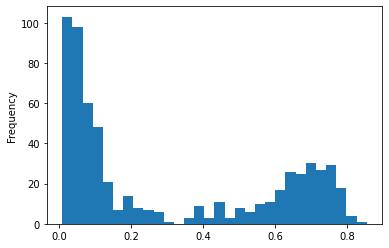

In [3]:
# explore
df.ps.plot( kind='hist', bins=30)
df.ps.describe()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


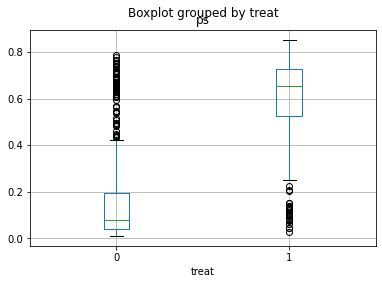

In [18]:
# assess common support
df.boxplot(column='ps', by='treat')

In [5]:
# calculate propensity score weights for ATT (Austin, 2011) and ATE
#df['wt'] = np.where(df['treat']==1, 1,df.ps/(1-df.ps))
df['wt_ATE'] = np.where(df['treat']==1, 1/df.ps,1/(1-df.ps))
df['wt_ATT'] = np.where(df['treat']==1, 1,df.ps/(1-df.ps))

df.wt_ATT.describe() # check
df.wt_ATE.describe() # check

count    614.000000
mean       1.904940
std        2.611408
min        1.009163
25%        1.051588
50%        1.169745
75%        1.623320
max       40.077294
Name: wt_ATE, dtype: float64

In [6]:
# split data and use numpy to deal with pandas issues elated to using group by with means on integer 0/1 values
trt = df[df['treat'].isin([1])]  
ctrl =df[df['treat'].isin([0])] 

In [7]:
col_name_uw=['Unweighted','treat','ctrl']
df_temp=[['Whether Black',np.average(trt.black),np.average(ctrl.black)],
         ['Re74',np.average(trt.re74),np.average(ctrl.re74)],
         ['Age',np.average(trt.age),np.average(ctrl.age)]]
df_uw=pd.DataFrame(df_temp,columns=col_name_uw)
df_uw

,Unweighted,treat,ctrl
0,Whether Black,0.843243,0.202797
1,Re74,2095.573689,5619.236506
2,Age,25.816216,28.030303


In [19]:
col_name_w=['Weighted','treat','ctrl']
df_temp=[['Whether Black',np.average(trt.black, weights =  trt.wt_ATT),np.average(ctrl.black, weights =  ctrl.wt_ATT)],
         ['Re74',np.average(trt.re74, weights =  trt.wt_ATT),np.average(ctrl.re74, weights =  ctrl.wt_ATT)],
         ['Age',np.average(trt.age, weights =  trt.wt_ATT),np.average(ctrl.age, weights =  ctrl.wt_ATT)]]
df_w=pd.DataFrame(df_temp,columns=col_name_w)
df_w

,Weighted,treat,ctrl
0,Whether Black,0.843243,0.845480
1,Re74,2095.573689,2106.044819
2,Age,25.816216,24.965845


#### Estimation of treatment effects

##### unweighted comparisons

In [9]:
# regression using smf
lmresults = smf.ols('re78 ~ treat', data=df).fit()

# inspect results
lmresults.summary()  # b_est = -635

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9338
Date:                Tue, 03 Jan 2023   Prob (F-statistic):              0.334
Time:                        20:31:19   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6984.1697    360.710     19.362      0.000    6275.791    7692.549
treat       -635.0262    657.137     -0.966      0.334   -1925.544     655.492
==============================================================================
Omnibus:                      209.619   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.567
Skew:                           1.567   Prob(JB):                    3.87e-169
Kurtosis:                       7.527   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### weighted comparisons using mean

In [10]:
# weighted differences in outcome
print(np.average(trt.re78, weights =  trt.wt_ATT))
print(np.average(ctrl.re78, weights = ctrl.wt_ATT))

6349.143530270271
5135.0723069774185


##### weighted comparisons using regression pkg

In [11]:
### weighted comparisons

# iptw regression
iptwResults = smf.wls('re78 ~ treat', data=df, weights = df.wt_ATT).fit()
iptwResults.summary() # b_est =  1214

# this result if very similar to the result using R Matchit 
# see: https://gist.github.com/BioSciEconomist/6e8b3fba57d00761527215128bdbf11a 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.554
Date:                Tue, 03 Jan 2023   Prob (F-statistic):             0.0332
Time:                        20:31:19   Log-Likelihood:                -6617.9
No. Observations:                 614   AIC:                         1.324e+04
Df Residuals:                     612   BIC:                         1.325e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5135.0723    401.194     12.799      0.000    4347.189    5922.956
treat       1214.0712    568.904      2.134      0.033      96.830    2331.312
==============================================================================
Omnibus:                      433.793   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9596.350
Skew:                           2.826   Prob(JB):                         0.00
Kurtosis:                      21.524   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### weighted comparisons from scratch

In [12]:
# Prepare matrices
y=df['re78'].values
df['cons']=1
x=df[['treat','cons']].values
w=np.diag(df['wt_ATT'].values)

In [13]:
# get point estimate
# see here for the formula: https://ms.mcmaster.ca/canty/teaching/stat3a03/Lectures7.pdf
beta=np.matmul(np.linalg.inv(np.matmul(np.matmul(x.T,w),x)),np.matmul(np.matmul(x.T,w),y))
beta

array([1214.07122329, 5135.07230698])

In [14]:
# prepare to calculate Standard Errors
# see here for the formula: https://stats.stackexchange.com/questions/283764/standard-errors-with-weighted-least-squares-regression
df['y_hat']=np.dot(x,beta.reshape(-1,1)).copy()
df['resid']=df['re78']-df['y_hat']
df['resid_2']=df['resid']*df['resid']

In [15]:
SE=np.sqrt((np.sqrt(sum(df['wt_ATT']*df['resid_2'])/(len(df)-2)))**2*np.linalg.inv(np.matmul(np.matmul(x.T,w),x)).diagonal())
SE # matches the WLS result above

array([568.90402258, 401.19365903])

In [16]:
# calcualte t-statistics
1214.0712/568.904

2.134052845471292

In [17]:
# calculate P value
2*(1 - t.cdf(abs(2.134052845471292), len(df)-2)) 

0.03323530034399158